In [92]:
import librosa
import librosa.display
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio
import resampy

import tensorflow as tf
import keras as K

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

# Be sure to set this after downloading the dataset!
DATA_ROOT = '/beegfs/qx244/ds/openmic-2018/'

if not os.path.exists(DATA_ROOT):
    raise ValueError('Did you forget to set `DATA_ROOT`?')

In [ ]:
import tom

In [2]:
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'))

In [3]:
# It will be easier to use if we make direct variable names for everything
Y_true, Y_mask, sample_key = OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

### What's included in the data?

- `X`: 20000 * 10 * 128 array of VGGish features
    - First index (0..19999) corresponds to the sample key
    - Second index (0..9) corresponds to the time within the clip (each time slice is 960 ms long)
    - Third index (0..127) corresponds to the VGGish features at each point in the 10sec clip
    - Example `X[40, 8]` is the 128-dimensional feature vector for the 9th time slice in the 41st example
- `Y_true`: 20000 * 20 array of *true* label probabilities
    - First index corresponds to sample key, as above
    - Second index corresponds to the label class (accordion, ..., voice)
    - Example: `Y[40, 4]` indicates the confidence that example #41 contains the 5th instrument
- `Y_mask`: 20000 * 20 binary mask values
    - First index corresponds to sample key
    - Second index corresponds to the label class
    - Example: `Y[40, 4]` indicates whether or not we have observations for the 5th instrument for example #41
- `sample_key`: 20000 array of sample key strings
    - Example: `sample_key[40]` is the sample key for example #41

In [4]:
with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:
    class_map = json.load(f)

In [19]:
# Let's split the data into the training and test set
# We use squeeze=True here to return a single array for each, rather than a full DataFrame

split_train = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_train.csv'),                         
                          header=None, squeeze=True)
split_test = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_test.csv'), 
                         header=None, squeeze=True)
train_set = set(split_train)
test_set = set(split_test)

In [20]:
split_train.head(5)

0      000046_3840
1    000135_483840
2    000139_119040
3    000141_153600
4     000144_30720
Name: 0, dtype: object

In [21]:
split_train[0]

'000046_3840'

In [22]:
Y_true[10] 

array([0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   ,
       0.5   , 0.5   , 0.    , 0.5   , 0.8243, 0.5   , 0.5   , 0.5   ,
       0.5   , 0.5   , 0.5   , 0.5   ])

In [23]:
Y_mask[10]

array([False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False])

In [24]:
Y_masked_tf = tf.multiply(Y_true, Y_mask)

In [25]:
with tf.Session() as sess:
    Y_masked = sess.run(Y_masked_tf)

In [26]:
Y_masked.shape

(20000, 20)

In [27]:
# These loops go through all sample keys, and save their row numbers
# to either idx_train or idx_test
#
# This will be useful in the next step for slicing the array data
idx_train, idx_test = [], []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(sample_key[n]))
        
# Finally, cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [32]:
X_train_path = sample_key[idx_train[:500]]
Y_train = Y_masked[idx_train[:500]]
X_test_path = sample_key[idx_test[:50]]
Y_test = Y_masked[idx_test[:50]]

In [35]:
# x_id = '001521_38400'
# excerpt_path = os.path.join(DATA_ROOT, 'audio/'+x_id[:3]+'/'+x_id+'.ogg')
# y, sr = sf.read(excerpt_path)

In [ ]:
def compute_mel_feature(x_id):
    excerpt_path = os.path.join(DATA_ROOT, 'audio/'+x_id[:3]+'/'+x_id+'.ogg')
    y, sr = sf.read(excerpt_path)
    if sr != 44100:
        print('resampling excerpt %s from original sr %d'.format(x_id, sr))
        y = resampy.resample(y, sr, 44100)
    # Make Mono
    if y.ndim == 2:
        y = y.mean(axis=-1)
    melspec = librosa.feature.melspectrogram(y=y, sr=44100, 
                                             n_fft=2048, hop_length=512)
    return melspec

In [97]:
X_train = []
for i, x_id in enumerate(X_train_path):   
    if i%10 == 0: 
        print(x_id)
    mel = compute_mel_feature(x_id)
    X_train.append(compute_mel_feature(x_id))
X_train = np.array(X_train)
    
X_test = []
for x_id in X_test_path:
    if i%10 == 0: 
        print(x_id)
    mel = compute_mel_feature(x_id)
    X_test.append(compute_mel_feature(x_id))  
X_test = np.array(X_test)

000046_3840
000046_3840 (128, 862)
000195_280320
000247_76800
000386_65280
000473_138240
000575_69120
000606_15360 (128, 431)
000608_34560 (128, 862)
000640_49920
000693_307200
000764_172800
000873_253440
001050_0
001135_23040
001216_610560
001299_149760
001521_38400
001561_360960
001658_65280 (128, 938)
001668_391680 (128, 862)
001683_11520
001726_295680
001918_61440
001986_72960
003260_145920
003459_69120
003521_34560
003560_80640
003689_138240
003744_119040
003775_103680
003837_537600
003875_264960
003972_284160
004041_291840
004084_3840
004164_19200
004235_272640
004394_157440
004453_111360
004524_1190400
004713_149760
004994_3840
005029_11520
005050_115200
005158_11520
005370_149760
005873_65280
006330_130560
006376_65280
006464_34560
006636_1774080
006776_203520
006859_11520


In [60]:
small_list = [np.array([1,2,3]), np.array([1,2,3])]

In [63]:
t2 = np.array(small_list)

In [65]:
t3 = np.array([t2,t2])

In [85]:
for x in X_train[54:57]:
    print(x.shape)

(128, 862)
(128, 431)
(128, 431)


In [88]:
train_idx[54:57]

54     000605_3840
55    000606_15360
56    000607_76800
Name: 0, dtype: object

In [ ]:
x_ids = ['000606_15360', '001658_65280']
excerpt_path = os.path.join(DATA_ROOT, 'audio/'+x_ids[0][:3]+'/'+x_id+'.ogg')


## Load Audio File

Try to load the audio given a index

In [87]:
excerpt_idx = split_train[4]

plting = False
n_mels = 128
n_fft = 2048
hop_length = 512

hop_time = hop_length/float(sr)




In [88]:
excerpt_path = os.path.join(DATA_ROOT, 'audio/'+excerpt_idx[:3]+'/'+excerpt_idx+'.ogg')
y, sr = sf.read(excerpt_path)
# Make Mono
y = y.mean(axis=-1)

## compute mel spectrogram

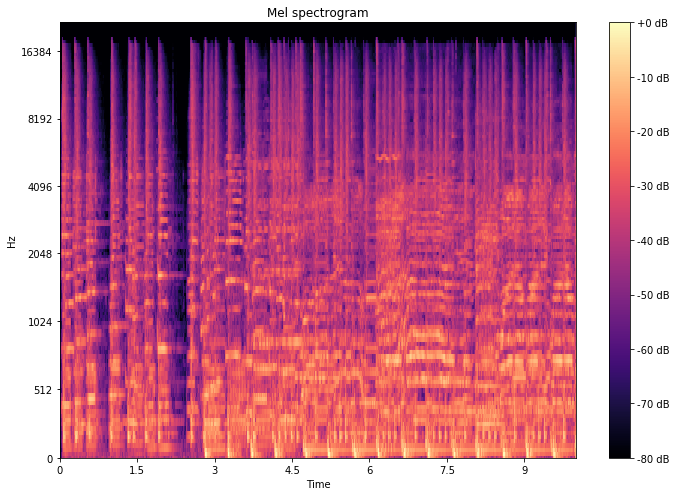

In [89]:
melspec = librosa.feature.melspectrogram(y=y, sr=sr, 
                                         n_fft=n_fft, hop_length=hop_length)

if plting == True:
    plt.figure(figsize=(10,7))
    librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),
                             sr=sr, 
                             hop_length=hop_length, 
                             y_axis='mel', 
                             fmax=sr/2.0,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()

## Save melspec to disk

In [90]:
Audio(data=y,rate=sr)

In [97]:
melspec_tensor = melspec.T